## POSTPROECESSING

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import neptune
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_label_contours
from MODULES.utilities_visualization import plot_segmentation, movie_from_resolution_sweep
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict, load_obj
from MODULES.utilities_visualization import contours_from_labels, add_red_contours
import skimage.io
from IPython.display import HTML
from matplotlib import animation

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

python_version() --->  3.7.7
torch.__version__ -->  1.5.0


### Import the files

In [3]:
params = load_json_as_dict("./ML_parameters.json")
preprocessed = load_obj("streamlined_8_smFISH_stitched_OLEH.tif")
ckpt = file2ckpt(path="./last_ckpt.pt", device=None)
tiling = load_obj("./tiling.pt")

img_torch = preprocessed.img.float()
roi_mask_torch = preprocessed.roi_mask.bool()

vae = CompositionalVae(params)
load_from_ckpt(ckpt=ckpt,
               model=vae,
               optimizer=None,
               overwrite_member_var=False)

### Image to segment

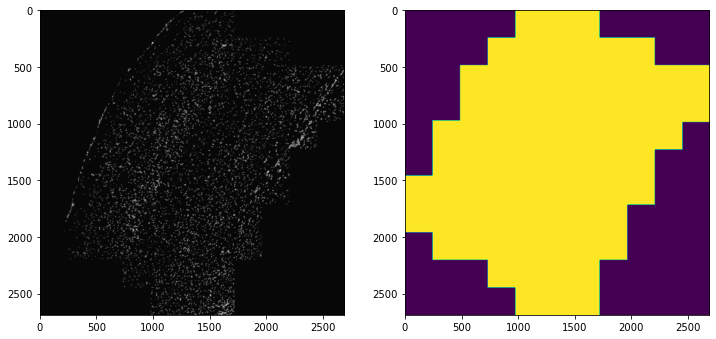

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(12,12))
ax[0].imshow(img_torch[0, 0], cmap='gray')
ax[1].imshow(roi_mask_torch[0, 0])

### Compute the tiling

In [5]:
#with torch.no_grad():
#    start_time = time.time()
#    tiling: Segmentation = vae.segment_with_tiling(single_img=img_torch[0],
#                                                   roi_mask=roi_mask_torch[0],
#                                                   crop_size=None,
#                                                   stride=(20, 20),
#                                                   n_objects_max_per_patch=None,
#                                                   prob_corr_factor=None,
#                                                   overlap_threshold=None,
#                                                   radius_nn=10,
#                                                   batch_size=128)
#    print("tiling time",time.time()-start_time)
#save_obj(tiling, "tiling_large.pt")
tiling = load_obj("tiling_large.pt")

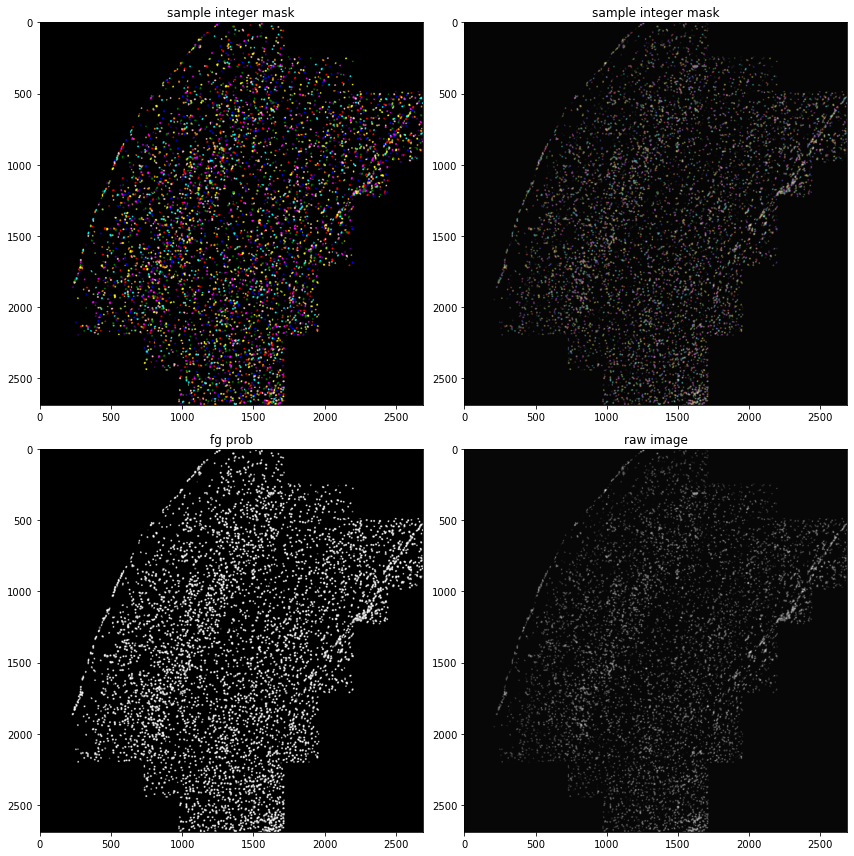

In [6]:
tiling_fig_large = plot_tiling(tiling, window=None, neptune_name=None)
tiling_fig_large

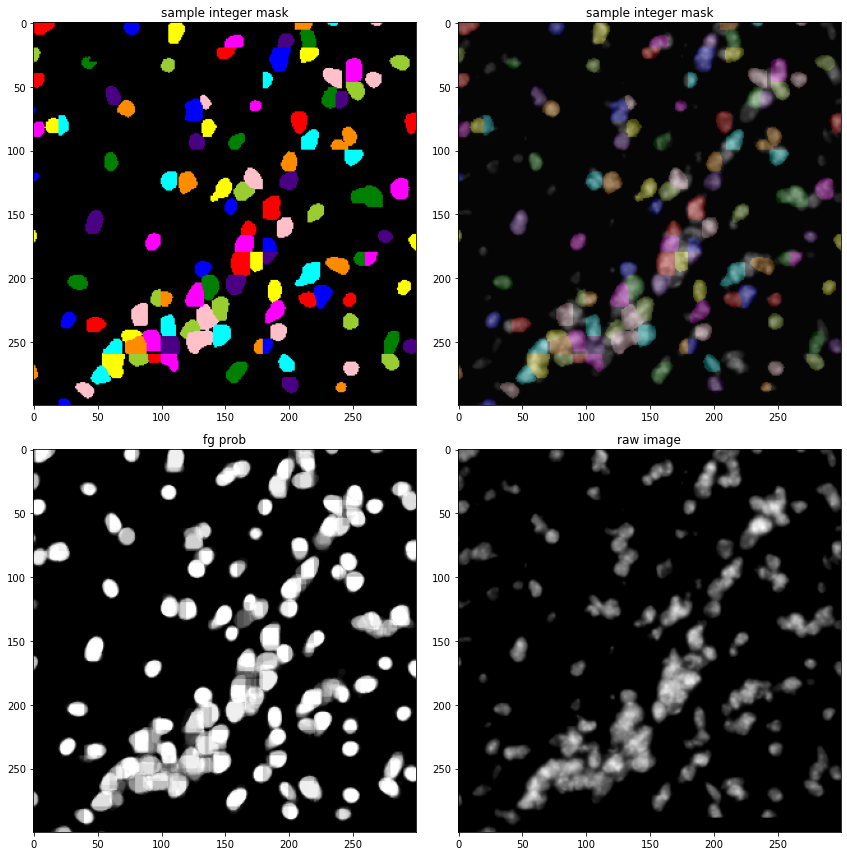

In [7]:
ix, iy, size = 940, 2140, 300
window = [ix, iy, ix+size, iy+size]
tiling_fig_small = plot_tiling(tiling, window=window, neptune_name=None)
tiling_fig_small

### Create graph

In [8]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

Building the graph with python-igraph
756552
356716.625


'IGRAPH U-W- 756552 68389669 -- \n+ attr: total_edge_weight (g), total_nodes (g), label (v), weight (e)'

### Plot segmentation before graph approach

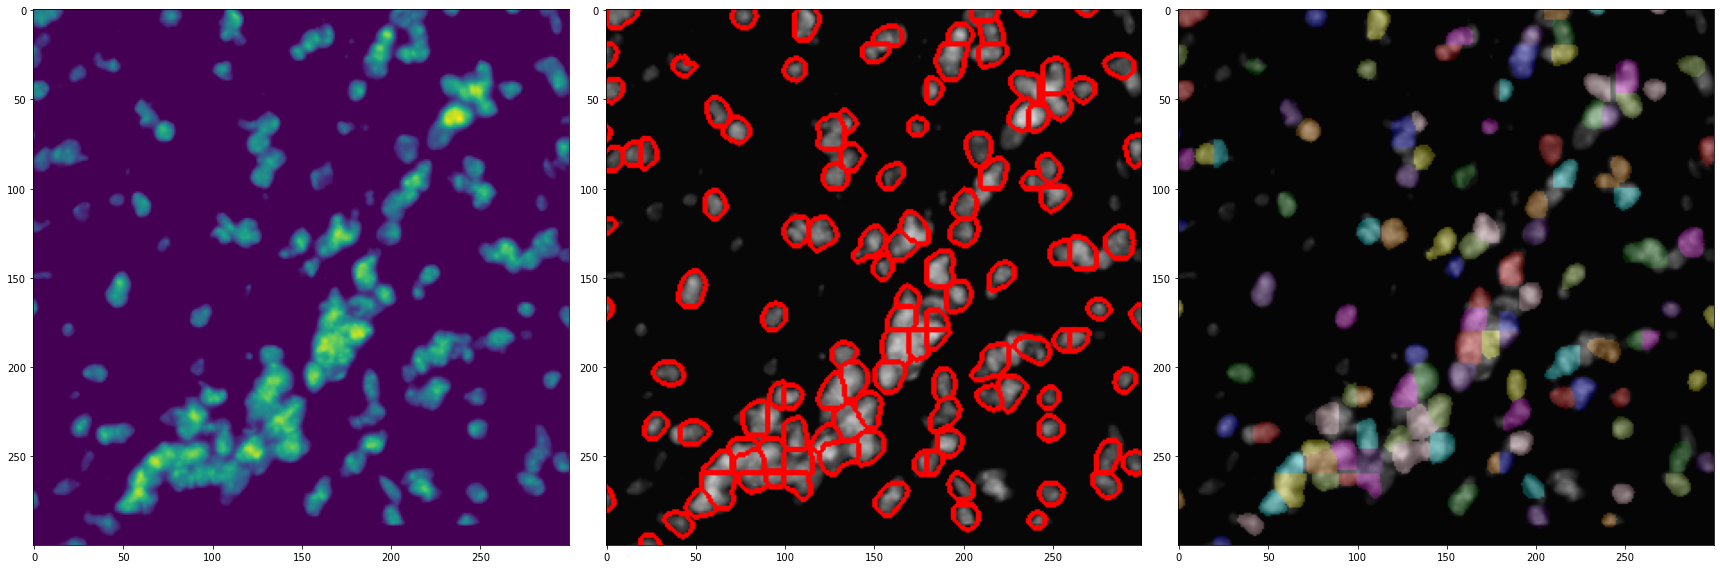

In [9]:
plot_label_contours(label=tiling.integer_mask[0,0],
                    image=tiling.raw_image[0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

### Perform sweep on a small window

In [10]:
# sweep = numpy.arange(1.0, 20.0)
sweep = numpy.linspace(start=1, stop=800, num=20)
print(sweep)
suggestion_mod_true = g.suggest_resolution_parameter(min_size=20,
                                                     window=window,
                                                     cpm_or_modularity="modularity",
                                                     each_cc_separately=False,
                                                     sweep_range=sweep)

[  1.          43.05263158  85.10526316 127.15789474 169.21052632
 211.26315789 253.31578947 295.36842105 337.42105263 379.47368421
 421.52631579 463.57894737 505.63157895 547.68421053 589.73684211
 631.78947368 673.84210526 715.89473684 757.94736842 800.        ]
tensor([  0,   0,   0,  ..., 118, 119, 120], device='cuda:0')
resolution sweep,   0 out of  19
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  10 out of  19
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  19 out of  19
find partition internal


### See the sweep

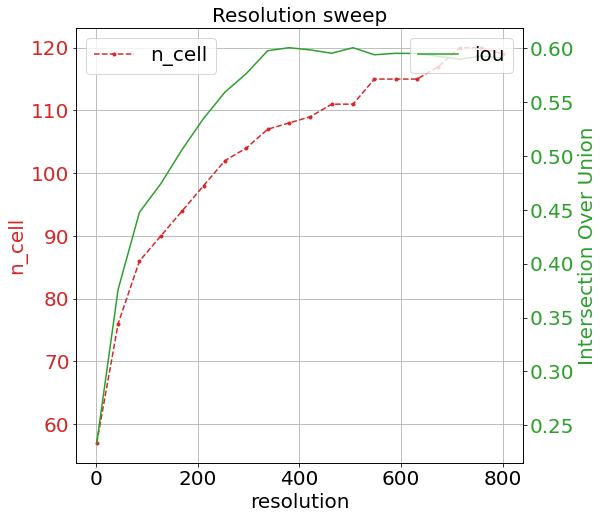

In [12]:
suggestion_mod_true.show_graph(figsize=(8,8))


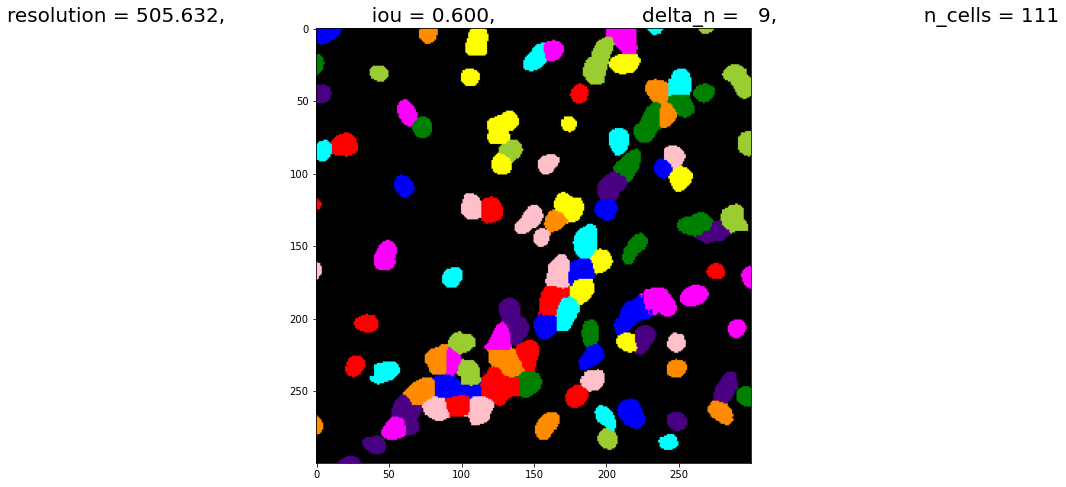

In [13]:
suggestion_mod_true.show_best(figsize=(8,8))

In [14]:
movie_from_resolution_sweep(suggestion_mod_true, tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]])

### Do community detection with the chiosen resolution parameter

In [ ]:
start_time = time.time()
resolution = 400.0

partition = g.find_partition_leiden(resolution=resolution, 
                                    min_size=20, 
                                    cpm_or_modularity="modularity", 
                                    each_cc_separately=False,
                                    n_iterations=10,
                                    initial_membership=None) 
print("community detection time",time.time()-start_time)

### Vefiry results on the small window

In [ ]:
plot_label_contours(label=g.example_integer_mask,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

# Import files

In [ ]:
#tiling_file = "/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/merfish_aug_5_v1/tiling_aug7_radius5.pt"
#tiling_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_aug_5_v1/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_segment_june27_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v6/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100_LARGE.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_18_v1/tiling_17500_SMALL.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_18_v1/tiling_17500_LARGE.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_19_v1/tiling_SMALL.pt"
tiling_file = "NEW_ARCHIVE/merfish_aug_19_v1/tiling_LARGE.pt"

tiling = load_obj(tiling_file)

# Graph Segmentation
Use small windows first. When satisfied run on entire image

In [ ]:
window = None
window = (1000, 2100, 1300, 2400)

plot_tiling(tiling, window)

In [ ]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)

In [ ]:
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

In [ ]:
start_time = time.time()
window = None
#window = (1000, 2100, 1300, 2400)

partition = g.find_partition_leiden(resolution=800.0, 
                                    window=window,
                                    min_size=30, 
                                    cpm_or_modularity="modularity", 
                                    each_cc_separately=False,
                                    n_iterations=10,
                                    initial_membership=None) 
print("community detection time",time.time()-start_time)

### Visualize Graph Segmentation

In [ ]:
#window = (1000, 2100, 1300, 2400)
window = None

if window is None:
    raw_image = tiling.raw_image[0,0].cpu().numpy()
    sample_segmax =  tiling.integer_mask[0,0].cpu().numpy()
    segmask = g.partition_2_mask(partition).cpu().numpy()
else:
    raw_image = tiling.raw_image[0,0].cpu().numpy()[window[0]:window[2],window[1]:window[3]]
    sample_segmax =  tiling.integer_mask[0,0].cpu().numpy()[window[0]:window[2],window[1]:window[3]]
    segmask = g.partition_2_mask(partition).cpu().numpy()[window[0]:window[2],window[1]:window[3]]

min_area = 30
seg_mask = QC_on_mask(segmask, min_area)

In [ ]:
g.plot_partition(partition, window=window, figsize=(12, 12))

In [ ]:
plot_mask_with_contours(sample_segmax, raw_image, contour_thickness=2)

In [ ]:
plot_mask_with_contours(seg_mask, raw_image, contour_thickness=2)

In [ ]:
# Make sure that instances are connected and above a certain size
output_dir = os.path.dirname(tiling_file)
output_segmentation = os.path.join(output_dir,"segmentation.tiff")
output_contours = os.path.join(output_dir,"contours.tiff")

contours = contours_from_segmask(segmask, thickness=2)
image_with_contours = add_red_contours(raw_image, contours)

print(seg_mask.dtype)
print(image_with_contours.dtype)

skimage.io.imsave(output_segmentation, seg_mask)
skimage.io.imsave(output_contours, image_with_contours)

# DO A SWEEP IF NECESSARY

### Graph with normalization

In [ ]:
window = (1000, 2100, 1300, 2400)


In [ ]:
g1 = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g1.graph["total_nodes"])
print(g1.graph["total_edge_weight"])

In [ ]:
sweep_cpm1 = g1.suggest_resolution_parameter(window = window, 
                                             min_size = 20,
                                             max_size = None,
                                             cpm_or_modularity = "cpm",
                                             each_cc_separately = False,
                                             sweep_range = numpy.arange(1.0,20.0,1.0)) 
sweep_modularity1 = g1.suggest_resolution_parameter(window = window, 
                                                  min_size = 20,
                                                  max_size = None,
                                                  cpm_or_modularity = "modularity",
                                                  each_cc_separately = False,
                                                  sweep_range = numpy.arange(1.0,20.0,1.0)) 

In [ ]:
#sweep_cpm1.show_graph(figsize=(12,12))
#sweep_modularity1.show_graph(figsize=(12,12))
#sweep_modularity1.show_best()
#sweep_cpm1.show_best()

### Graph without normalization

In [ ]:
g2 = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=False)
print(g2.graph["total_nodes"])
print(g2.graph["total_edge_weight"])

In [ ]:
sweep_cpm2 = g2.suggest_resolution_parameter(window = window, 
                                             min_size = 20,
                                             max_size = None,
                                             cpm_or_modularity = "cpm",
                                             each_cc_separately = False,
                                             sweep_range = numpy.arange(1.0,20.0,1.0)) 
sweep_modularity2 = g2.suggest_resolution_parameter(window = window, 
                                                  min_size = 20,
                                                  max_size = None,
                                                  cpm_or_modularity = "modularity",
                                                  each_cc_separately = False,
                                                  sweep_range = numpy.arange(1.0,20.0,1.0)) 

## Compare sweeps by graphs 

In [ ]:
sweep_cpm1._fields

In [ ]:
plot_sweep_comparison('sweep_sizes', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2, index=-1, bins=25)

In [ ]:
plot_sweep_comparison('sweep_iou', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2)

In [ ]:
plot_sweep_comparison('sweep_n_cells', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2)

## Compare sweeps by movie

In [ ]:
if window is None:
    raw_image = tiling.raw_image[0,0].cpu().numpy()
else:
    raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()

In [ ]:
show_sweep_movie(suggestion=sweep_cpm1,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

In [ ]:
show_sweep_movie(suggestion=sweep_modularity1,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

In [ ]:
show_sweep_movie(suggestion=sweep_cpm2,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

In [ ]:
show_sweep_movie(suggestion=sweep_modularity2,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

## Compare sweep by segmentation

In [ ]:
#sweep_cpm2.show_graph(figsize=(12,12))
#sweep_modularity2.show_graph(figsize=(12,12))
#sweep_modularity2.show_best()
#sweep_cpm2.show_best()

In [ ]:
index=-10
print(sweep_modularity1.sweep_resolution[index])
plot_mask_image_overlay(seg_mask=sweep_modularity1.sweep_seg_mask[index],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
plot_mask_image_overlay(seg_mask=sweep_modularity2.sweep_seg_mask[-1],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
plot_mask_image_overlay(seg_mask=sweep_cpm1.sweep_seg_mask[-1],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
plot_mask_image_overlay(seg_mask=sweep_cpm2.sweep_seg_mask[-1],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

## Chose the best and visualize

In [ ]:
sweep_modularity1.show_index(index=-10, figsize=(12,12))

In [ ]:
if window is None:
    raw_image = tiling.raw_image[0,0].cpu().numpy()
else:
    raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()

In [ ]:
index=-10
print("resolution",sweep_modularity1.sweep_resolution[index])
plot_mask_image_overlay(seg_mask=sweep_modularity1.sweep_seg_mask[index],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
index=-1
print("resolution",sweep_modularity1.sweep_resolution[index])
plot_mask_image_overlay(seg_mask=sweep_modularity1.sweep_seg_mask[index],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))